In [1]:
import os
import glob
import numpy as np
import pandas as pd
import PIL.Image
import cv2
import h5py
import time
import pickle
from tqdm import tqdm

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.applications.inception_v3 import InceptionV3, preprocess_input

import matplotlib.pyplot as plt

import feature_axis.axis as axis

Using TensorFlow backend.


In [2]:
_path_root =  os.path.dirname(os.path.abspath(''))
_path_sample_jpg = _path_root + '/controlled_generation/feature_axis/assets/samples_jpg/'
_x_file_pattern = 'sample_*.jpg'
_z_file_pattern = 'sample_*_z.npy'
_filename_y = 'sample_y.h5'
_filename_z = 'sample_z.h5'
_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
_normalize_feature_direction = True

_img_width = 178
_img_height = 218

In [3]:
def gen_time_str():
    return time.strftime("%Y%m%d_%H%M%S", time.gmtime())

In [4]:
x_files = glob.glob(os.path.join(_path_sample_jpg, _x_file_pattern))
x_files.sort()

z_files = glob.glob(os.path.join(_path_sample_jpg, _z_file_pattern))
z_files.sort()

assert len(x_files) == len(z_files), 'same number of Z and X'

In [5]:
base_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(_img_width, _img_height, 3))

print("number of layers:", len(base_model.layers))

for layer in base_model.layers[:52]:
    layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


number of layers: 311
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
model.load_weights('inception_v3_eyeglasses.h5')

In [16]:
y_list = []
batch_size = 64
img_batch_list = []
x_files_used = x_files
n = len(x_files_used)
save_freq = 2048

for i, file in tqdm(enumerate(x_files_used)):
    img = np.asarray(PIL.Image.open(file))
    img = cv2.resize(img, dsize=(_img_height, _img_width), interpolation=cv2.INTER_CUBIC)
    img_batch_list.append(img/255)
    
    if (i%batch_size) == (batch_size-1) or i == (n-1):
        img_batch = np.stack(img_batch_list, axis=0)
        img_batch = preprocess_input(img_batch)
        y = model.predict(img_batch, batch_size=batch_size)
        y_list.append(y)
        img_batch_list = []
        
        if i % save_freq == _img_height:
            y_concat = np.concatenate(y_list, axis=0)
            with h5py.File(_filename_y, 'w') as f:
                f.create_dataset('y', data=y_concat)
                
y_concat = np.concatenate(y_list, axis=0)     
with h5py.File(_filename_y, 'w') as f:
    f.create_dataset('y', data=y_concat)

48696it [02:38, 307.23it/s]


In [19]:
with h5py.File(_filename_y, 'r') as f:
    y = f['y'][:]

with h5py.File(_filename_z, 'r') as f:
    z = f['z'][:]

In [24]:
from custom_gen import StyleGANGenerator
gen = StyleGANGenerator(_stylegan_ffhq_f_gdrive_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [35]:
img = gen.get_images(np.reshape(z[44], (1,512)))

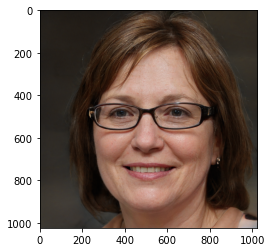

In [36]:
plt.imshow(img[0]/255)

In [28]:
y[586]

array([0.43087742], dtype=float32)

In [102]:
df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})[['Eyeglasses']
df.head()

,Eyeglasses,Smiling,Wearing_Lipstick,No_Beard,Young
0,0,1,1,1,1
1,0,1,0,1,1
2,0,0,0,1,1
3,0,0,1,1,1
4,0,0,1,1,1


In [103]:
y_name = df.columns.to_list()
y_name

['Eyeglasses', 'Smiling', 'Wearing_Lipstick', 'No_Beard', 'Young']

In [110]:
feature_slope = axis.find_feature_axis(z, y)

In [114]:
if _normalize_feature_direction:
    feature_direction = axis.normalize_feature_axis(feature_slope)
else:
    feature_direction = feature_slope

In [123]:
feature_direction_file = 'feature_direction_{}.pkl'.format(gen_time_str())
dict_to_save = {'direction': feature_direction, 'name': y_name}
with open(feature_direction_file, 'wb') as f:
    pickle.dump(dict_to_save, f)